# Statistical Analysis
In this file, we will perform **statistical analysis** for the ASUU Strike Effect Analysis Project. The statistical analysis performed will be based on the result of the **exploratory data analysis**.

## Importing necessary models

In [4]:
from scipy.stats import f_oneway, kruskal, ttest_ind, anderson
import scikit_posthocs as sp
from scipy import stats
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import utils
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [5]:
grey = "#eeeeee"
blue = "#4276A5"
red = "#cf8989"
cream = "#f9cb9c"
green = "#45818e"
pink = "#FF8FC3"

PALETTE = [red, cream, blue, green, pink, grey]
FONT = "Verdana"

# Set Seaborn style and color palette
sns.set(
    style="white", 
    palette=PALETTE, 
    context='notebook', 
    font=FONT, 
    font_scale=0.85, 
    color_codes=True
    )

# Set Matplotlib font
mpl.rcParams['font.family'] = FONT

# Set the desired axes border linewidth
mpl.rcParams['axes.linewidth'] = 0.2

This is temporary, for some reason, utils isn't working.

In [6]:
def anova_assumptions_test(feature, target, df):
    '''
    This function tests the assumptions required for the ANOVA statistical test.

    feature: The feature being tested for ANOVA assumptions.
    target: The column to aggregate for ANOVA.
    df: The dataframe containing the data.

    Returns one of four strings:
    1. The given data passes both tests of homoscedasticity and normality.
    2. The given data passes the test of homoscedasticity but fails the test of normality.
    3. The given data passes the test of normality but fails the test of homoscedasticity.
    4. The given data fails both tests of homoscedasticity and normality.
    '''
    # Homoscedasticity
    feature_std = df.groupby(feature)[target].std()
    max_std = feature_std.max()
    min_std = feature_std.min()

    # Normality
    normality = anderson_darling(df=df, feature=feature, target=target, alpha=5)

    if min_std * 2 >= max_std and normality:
        return 'The given data passes both tests of homoscedasticity and normality.'
    elif min_std * 2 >= max_std and not normality:
        return 'The given data passes the test of homoscedasticity but fails the test of normality.'
    elif min_std * 2 < max_std and normality:
        return 'The given data passes the test of normality but fails the test of homoscedasticity.'
    else:
        return 'The given data fails both tests of homoscedasticity and normality.'


def anderson_darling(df,feature,alpha,target):
  '''
  This function tests for normality in the df.
  
  df: The dataframe that contains the df you want to test.
  feature: The feature being tested for normality.
  target: The column to aggregate.
  alpha: The significance level for the statistical test. Default 0.05 or 5%.                                                   
  alpha should be inserted as a percentage in integer form, eg, 5% should be inserted as 5.
  
  Returns: True or False
  True means that the data follows a normal distribution.
  False means that the data doesn't follows a normal distribution.
  '''
  unique = df[feature].unique()
  counter = []

  for unique_value in unique:
    test_data = df[df[feature]==unique_value][target]
    
    if len(test_data) < 5:
        pass
    
    else:
        result = anderson(test_data)
        test_statistic = result.statistic
        critical_values = list(result.critical_values)
        significance_level = list(result.significance_level)
        index_sig_level = significance_level.index(alpha)

        if test_statistic <= critical_values[index_sig_level]:
            # It follows a normal distribution.
            counter.append(True)
        
        else:
            # It does not follow a normal distribution
            pass
    
  if False in counter:
      return False
  else:
      return True
  

def perform_one_way_anova(df, feature, target):
    '''
    Perform a one-way ANOVA test to assess the equality of means among multiple groups.
    
    Parameters:
        df (DataFrame): The DataFrame containing the data.
        feature (str): The column name for the categorical levels.
        target (str): The column name for the continuous variable (CGPA change).

    Returns:
        result (F_onewayResult): The result of the one-way ANOVA test.
    '''
    unique_levels = df[feature].unique()
    levels_data = {level: df[df[feature] == level][target] for level in unique_levels}
    
    result = f_oneway(*levels_data.values())
    
    return (f'ANOVA F-statistic:", {result.statistic}, "ANOVA p-value:", {result.pvalue}')


def perform_pairwise_tukeyhsd(df, feature, target):
    '''
    Perform pairwise Tukey's Honestly Significant Difference (HSD) test to compare group means.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        feature (str): The column name for the categorical groups.
        target (str): The column name for the data to be compared.

    Returns:
        tukey_result (MultiComparison): The result of the pairwise Tukey's HSD test.
    '''
    tukey_result = pairwise_tukeyhsd(
        endog=df[target],
        groups=df[feature]
    )
    print(tukey_result)
    
    
def perform_kruskal_willis_test(df, feature, target, min_count=5):
    '''
    Perform the Kruskal-Wallis test after filtering out groups with low counts.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        feature (str): The column name for the categorical groups.
        target (str): The column name for the data to be compared.
        min_count (int): Minimum count required for each group. Groups with counts below this are dropped.

    Returns:
        kruskal_result (KruskalResult): The result of the Kruskal-Wallis test.
    '''
    group_counts = df[feature].value_counts()
    low_count_groups = group_counts.index[group_counts < min_count]
    filtered_df = df[~df[feature].isin(low_count_groups)]

    groups_data = {group: filtered_df[filtered_df[feature] == group][target] for group in filtered_df[feature].unique()}

    kruskal_result = kruskal(*groups_data.values())
    return (f"Kruskal-Wallis Test statistic:, {kruskal_result.statistic}, Kruskal-Wallis Test p-value:, {kruskal_result.pvalue}")


def perform_pairwise_dunn(df, target, feature,p_adjust='bonferroni'):
    '''
    Perform pairwise Dunn's test to compare group means.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        feature (str): The column name for the categorical groups.
        target (str): The column name for the data to be compared.
        method (str): The multiple comparison correction method. Default is 'bonf'.
                      Other options: 'bonf', 'holm', 'fdr_bh', 'simes-hochberg'.

    Returns:
        dunn_result (DataFrame): The result of the pairwise Dunn's test.
    '''
    dunn_result = sp.posthoc_dunn(
        df[target],
        df[feature],
        p_adjust=p_adjust
    )
    print(dunn_result)
    

## Reading and previwing data

In [7]:
# all data here include predicted course units

# complete info
df = pd.read_csv("../data/data_with_predicted_course_units.csv")

# contains students with no cgpa before or after 
df_invalid_cgpa = pd.read_csv("../data/incomplete_cgpa_only.csv")

# only contains students with complete cgpa information
df_valid_cgpa = pd.read_csv("../data/valid_cgpa_only.csv")

In [8]:
df_valid_cgpa.head()

,school,level,age,gender,relationship,faculty,department,strike_effect,challenge,work,skills,prep_before,prep_after,lecture,academic_act,courses_taken,course_unit,cgpa_before,cgpa_after,cgpa_change
0,university of lagos,400 Level,22,Male,Single,Engineering,Chemical engineering,I learned how to study better and my grades al...,Trying to remember things we were taught befor...,Worked in a role relevant to my studies,Acquired skills unrelated to course of study,Poorly,Poorly,No noticeable change,Rarely: I engaged in academic activities once ...,10,23,3.39,3.51,0.12
1,university of lagos,400 Level,23,Female,Single,Engineering,Chemical engineering,It affected it in a negative way as it became ...,"Rekindling the student in me, lol. Trying to g...",Did not work during the strike,Acquired skills unrelated to course of study,Poorly,Moderately,No noticeable change,Rarely: I engaged in academic activities once ...,10,23,4.44,4.50,0.06
2,university of lagos,400 Level,21,Male,Dating,Engineering,Chemical engineering,It has actually helped me a bit. The extended ...,Readapting to school,Worked in a role unrelated to my studies,"Volunteered for an event or organization, Acqu...",Moderately,Moderately,Fewer lecturers attended classes,Rarely: I engaged in academic activities once ...,10,23,3.54,3.61,0.07
3,university of lagos,400 Level,29,Male,Dating,Social Sciences,Political science,Good,Reading,Worked in a role unrelated to my studies,Acquired skills unrelated to course of study,Moderately,Very,No noticeable change,Rarely: I engaged in academic activities once ...,7,1,3.86,3.96,0.10
4,university of lagos,300 Level,24,Male,Single,Education,Educational foundations,Reluctance to concentrate on my studies,Getting to dust my books and and assimilate,Did not work during the strike,None of the above,Poorly,Very,Worse lectures after the strike,Never: I did not engage in any academic activi...,9,18,2.85,2.00,-0.85


## Removing insignificant groups

In [9]:
# Dropping out-of-scope levels
df_valid_cgpa = df_valid_cgpa[~((df_valid_cgpa['level']=='600 Level') | (df_valid_cgpa['level']=='Masters Program') | (df_valid_cgpa['level']=='Postgraduate Diploma') | (df_valid_cgpa['level']=='100 Level'))]
df_valid_cgpa.level.unique()                                                                  

array(['400 Level', '300 Level', '200 Level', '500 Level'], dtype=object)

In [10]:
# Removing outlier row.
df_valid_cgpa = df_valid_cgpa[~(df_valid_cgpa['cgpa_change']==3.2)]

# Academic Level                                                                           

Feature: Academic Level

Null Hypothesis: There is no difference in the average cgpa change across academic levels.

Alternative Hypothesis: The Average cgpa change varies across academic levels.

Test Type: Two Tailed Test

Statistical Test: One Way ANOVA Test

Significance Level: 0.05

ANOVA Test Assumptions:
1. The samples are independent.
2. Each sample is from a normally distributed population.
3. The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

## Confirming Assumptions 

In [11]:
level_anova_assumptions = anova_assumptions_test(feature='level', target='cgpa_change', df=df_valid_cgpa)
print(level_anova_assumptions)

The given data passes both tests of homoscedasticity and normality.


## Hypothesis Testing on Academic Levels                                                                         

In [12]:
level_hypothesis_test = perform_one_way_anova(feature='level', target='cgpa_change', df=df_valid_cgpa)
level_hypothesis_test  

'ANOVA F-statistic:", 4.184646206134625, "ANOVA p-value:", 0.006365008572911084'

The p-value score of 0.0064 is less than the significance level of 0.05 this means that we reject the null hypothesis

**There is a significant difference between the average cgpa change across the different academic levels**                                                                     

## Interpreting the difference

While we've confirmed that a significant difference exist among the academic levels. The test carried out tells us nothing about the nature of this difference. To understand this difference, we can carry out post hoc tests to determine which specific pairs or groups differ significantly from the rest.                               

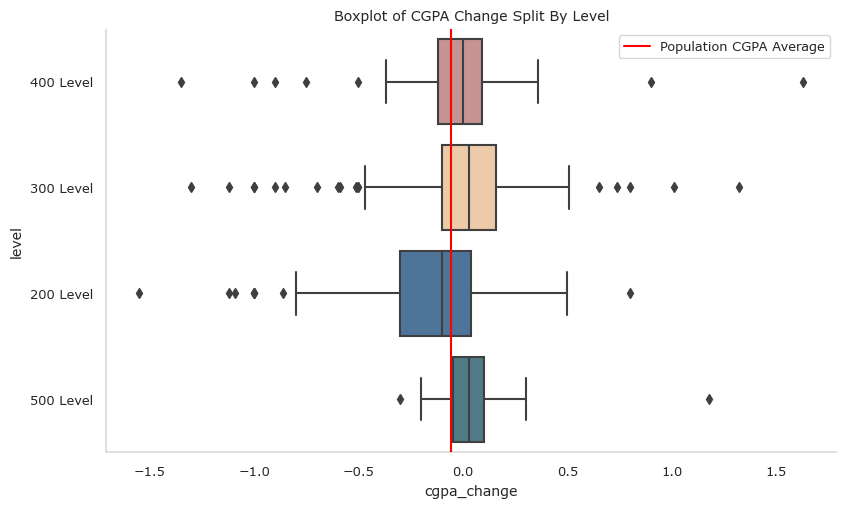

In [13]:
# Visualizing the difference
sns.catplot(
    kind='box',
    data=df_valid_cgpa,
    x='cgpa_change',
    y='level',
    aspect=12/7
)
plt.axvline(df_valid_cgpa.cgpa_change.mean(),color='red',label='Population CGPA Average')      
plt.legend(loc='upper right')                                                                           
plt.title('Boxplot of CGPA Change Split By Level');

In [14]:
# Investigating pairwise differences                                                                                 
level_tukey_results = perform_pairwise_tukeyhsd(feature='level', target='cgpa_change', df=df_valid_cgpa)
level_tukey_results

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj   lower  upper  reject
---------------------------------------------------------
200 Level 300 Level   0.1607 0.0125  0.0254  0.296   True
200 Level 400 Level   0.1299 0.1082 -0.0181  0.278  False
200 Level 500 Level   0.2355 0.0539 -0.0026 0.4737  False
300 Level 400 Level  -0.0308 0.9429 -0.1721 0.1105  False
300 Level 500 Level   0.0748 0.8423 -0.1592 0.3088  False
400 Level 500 Level   0.1056  0.672  -0.136 0.3472  False
---------------------------------------------------------


We can conclude from the reject column that there is a significant difference between the means of those in 200 and 300 level but no significant difference between any other group. This is supported visually. 200 level has the lowest 2nd quartile and 300 level has the highest 3 quartile. 

**The cgpa change of the 300 level students is significantly more than the cgpa change of 200 level students**

# Faculty

Feature: Faculty

Null Hypothesis: There is no difference in the average cgpa change across Faculty.

Alternative Hypothesis: The Average cgpa change varies across Faculty.

Test Type: Two Tailed Test

Statistical Test: One Way ANOVA Test

Significance Level: 0.05

ANOVA Test Assumptions:
1. The samples are independent.
2. Each sample is from a normally distributed population.
3. The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

## Confirming Assumptions 

In [15]:
faculty_anova_assumptions = anova_assumptions_test(feature='faculty', target='cgpa_change', df=df_valid_cgpa)
print(faculty_anova_assumptions)

The given data passes the test of normality but fails the test of homoscedasticity.


This feature fails homoscandesity test. We cannot use the Anova test to test the Hypothesis.

**We will use the Kruskal Willis Test.**
                                                       

## Hypothesis Testing on Faculty                                                                         

In [16]:
faculty_hypothesis_test = perform_kruskal_willis_test(feature='faculty', target='cgpa_change', df=df_valid_cgpa,min_count=5)
faculty_hypothesis_test  

'Kruskal-Wallis Test statistic:, 17.846018573361583, Kruskal-Wallis Test p-value:, 0.03700261022840909'

The p-value score of 0.037 is less than the significance level of 0.05 this means that we reject the null hypothesis

**There is a significant difference between the average cgpa change across the different faculties**

## Interpreting the difference

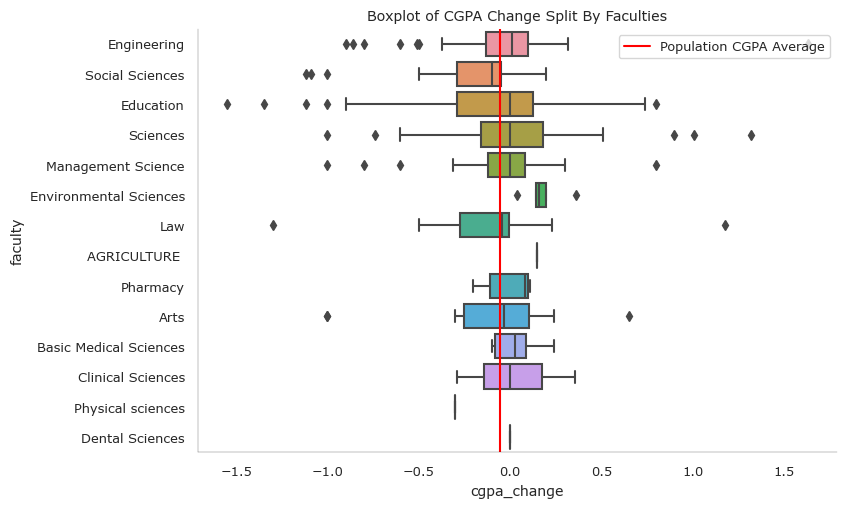

In [17]:
# Visualizing the difference
sns.catplot(
    kind='box',
    data=df_valid_cgpa,
    x='cgpa_change',
    y='faculty',
    aspect=12/7
)
plt.axvline(df_valid_cgpa.cgpa_change.mean(),color='red',label='Population CGPA Average')      
plt.legend(loc='upper right')                                                                           
plt.title('Boxplot of CGPA Change Split By Faculties');

In [18]:
# Investigating pairwise differences      
dunn_result=sp.posthoc_dunn(df_valid_cgpa,val_col='cgpa_change',group_col='faculty',p_adjust='holm')
dunn_result

,AGRICULTURE,Arts,Basic Medical Sciences,Clinical Sciences,Dental Sciences,Education,Engineering,Environmental Sciences,Law,Management Science,Pharmacy,Physical sciences,Sciences,Social Sciences
AGRICULTURE,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000
Arts,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000
Basic Medical Sciences,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000
Clinical Sciences,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000
Dental Sciences,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000
Education,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000
Engineering,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000
Environmental Sciences,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,0.074117
Law,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000
Management Science,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000


## RESOLUTION

Results are inconclusive. The hypothesis test and post hoc analysis directly contradict each other. Asides what's displayed on the notebook, I also tried different combinations of two more statistical testing methods (ANOVA and Tukey_usd) to similar results.                                              

# Age

Feature: Age

Null Hypothesis: There is no significant difference in the cgpa of students older and younger than 21.

Alternative Hypothesis: There is a significant difference in the cgpa of students older and younger than 21.

Test Type: Two Tailed Test

Statistical Test: One Way ANOVA Test

Significance Level: 0.05

ANOVA Test Assumptions:
1. The samples are independent.
2. Each sample is from a normally distributed population.
3. The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

## Preprocessing

In [19]:
def age_cat(row):
    if row <= 21:
        return 'Less Than 21'
    else:
        return 'Older Than 21' 
    
df_valid_cgpa_temporary = df_valid_cgpa.copy()
df_valid_cgpa_temporary['age_cat'] = df_valid_cgpa.age.apply(age_cat)

In [20]:
df_valid_cgpa_temporary.age_cat.unique()

array(['Older Than 21', 'Less Than 21'], dtype=object)

## Confirming Assumptions 

In [21]:
age_anova_assumptions = anova_assumptions_test(feature='age_cat', target='cgpa_change', df=df_valid_cgpa_temporary)
print(age_anova_assumptions)

The given data passes both tests of homoscedasticity and normality.


## Hypothesis Testing on Age                                                         

In [22]:
age_hypothesis_test = perform_one_way_anova(feature='age_cat', target='cgpa_change', df=df_valid_cgpa_temporary)
age_hypothesis_test  

'ANOVA F-statistic:", 0.13957190912191791, "ANOVA p-value:", 0.7089682217418058'

The p-value score of 0.709 is more than the significance level of 0.05 this means that we fail to reject the null hypothesis

**There is no significant difference between the average cgpa change across the different age classes**

## Interpreting the results

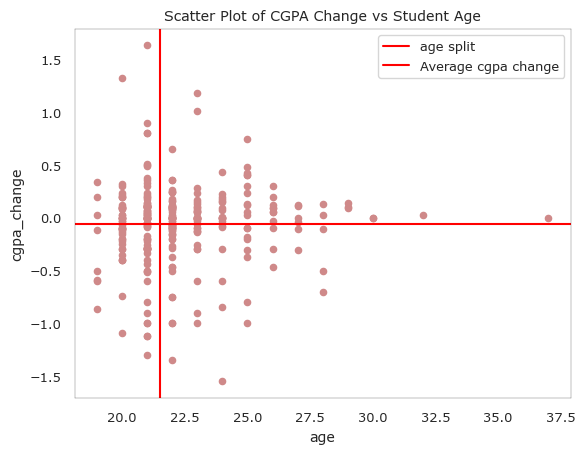

In [23]:
df_valid_cgpa.plot(kind='scatter',x='age',y='cgpa_change',title='Scatter Plot of CGPA Change vs Student Age')
plt.axvline(21.5,color='red',label='age split')
plt.axhline(df_valid_cgpa.cgpa_change.mean(),color='red', label='Average cgpa change')
plt.legend()

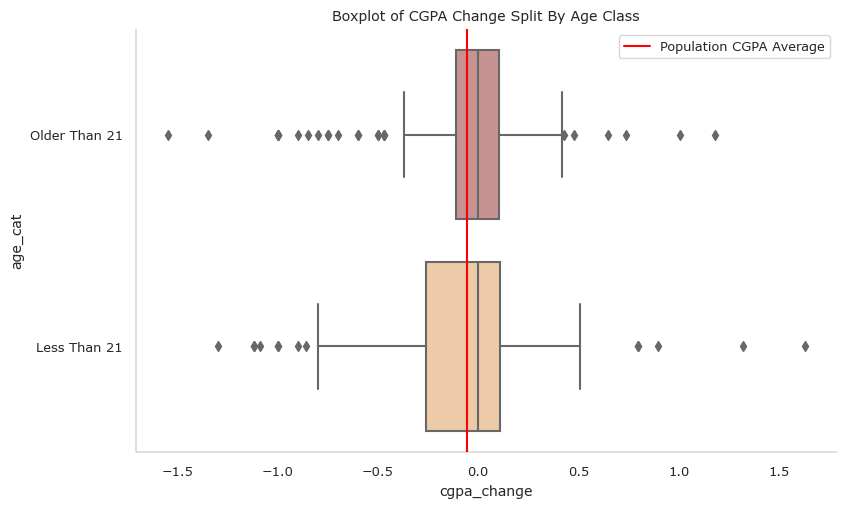

In [24]:
# Visualizing the difference
sns.catplot(
    kind='box',
    data=df_valid_cgpa_temporary,
    x='cgpa_change',
    y='age_cat',
    aspect=12/7
)
plt.axvline(df_valid_cgpa.cgpa_change.mean(),color='red',label='Population CGPA Average')      
plt.legend(loc='upper right')                                                                           
plt.title('Boxplot of CGPA Change Split By Age Class');

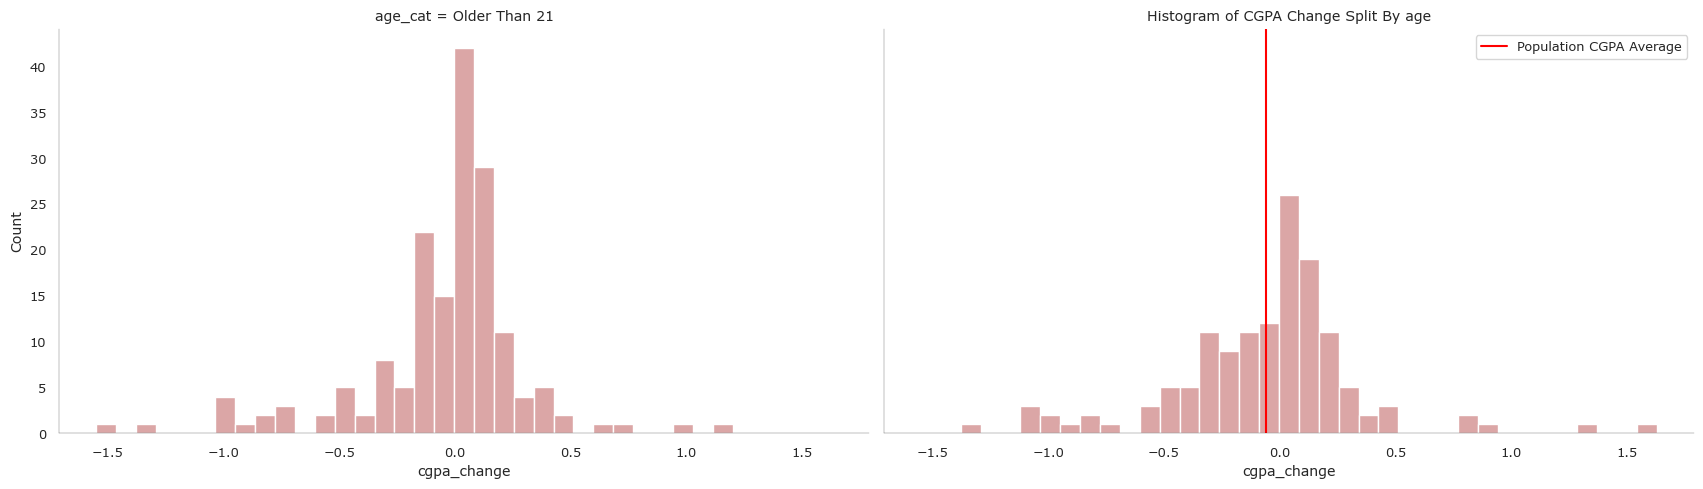

In [25]:
# Visualizing the results
sns.displot(
    kind='hist',
    data=df_valid_cgpa_temporary,
    x='cgpa_change',
    col='age_cat',
    aspect=12/7
)
plt.axvline(df_valid_cgpa.cgpa_change.mean(),color='red',label='Population CGPA Average')      
plt.legend(loc='upper right')                                                                           
plt.title('Histogram of CGPA Change Split By age');

The Boxplot and Histogram both confirm that the change in CGPA is independent of age class.                                                                    

# Gender

Feature: Gender

Null Hypothesis: There is no significant difference in the cgpa of males and females.

Alternative Hypothesis: There is no significant difference in the cgpa of students males and females

Test Type: Two Tailed Test

Statistical Test: One Way ANOVA Test

Significance Level: 0.05

ANOVA Test Assumptions:
1. The samples are independent.
2. Each sample is from a normally distributed population.
3. The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

## Confirming Assumptions 

In [26]:
dgenderanova_assumptions = anova_assumptions_test(feature='gender', target='cgpa_change', df=df_valid_cgpa)
print(dgenderanova_assumptions)

The given data passes both tests of homoscedasticity and normality.


## Hypothesis Testing on Gender                                             

In [27]:
gender_hypothesis_test = perform_one_way_anova(feature='gender', target='cgpa_change', df=df_valid_cgpa)
gender_hypothesis_test  

'ANOVA F-statistic:", 0.28331724825381116, "ANOVA p-value:", 0.5949252552984301'

The p-value score of 0.5949 is greater than the significance level of 0.05 this means that we fail to reject the null hypothesis

**There is no significant difference between the average cgpa change across the different genders**

## Interpreting the results

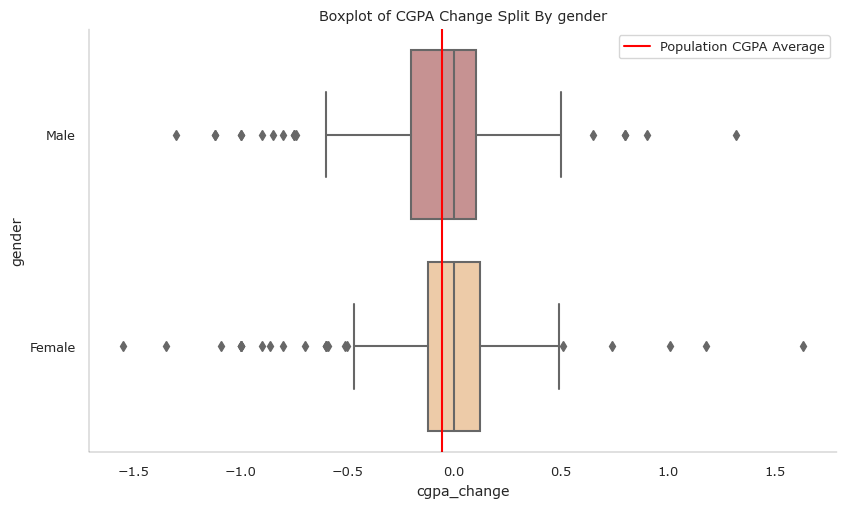

In [28]:
# Visualizing the results
sns.catplot(
    kind='box',
    data=df_valid_cgpa,
    x='cgpa_change',
    y='gender',
    aspect=12/7
)
plt.axvline(df_valid_cgpa.cgpa_change.mean(),color='red',label='Population CGPA Average')      
plt.legend(loc='upper right')                                                                           
plt.title('Boxplot of CGPA Change Split By gender');

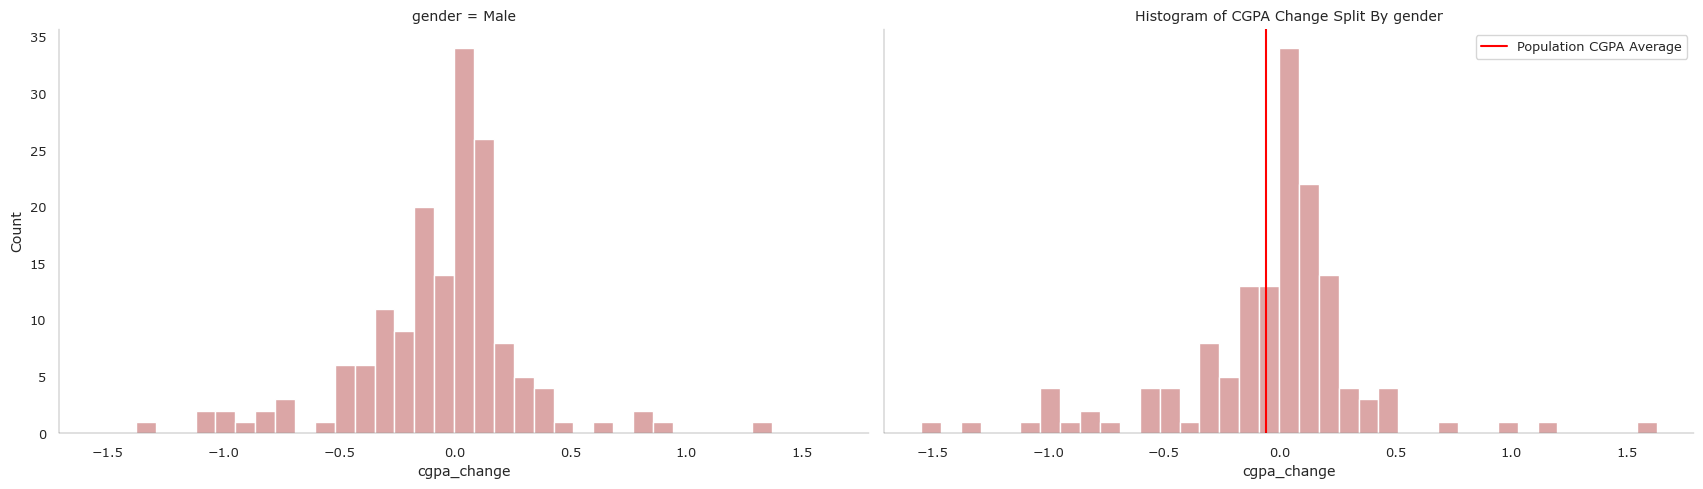

In [29]:
# Visualizing the results
sns.displot(
    kind='hist',
    data=df_valid_cgpa,
    x='cgpa_change',
    col='gender',
    aspect=12/7
)
plt.axvline(df_valid_cgpa.cgpa_change.mean(),color='red',label='Population CGPA Average')      
plt.legend(loc='upper right')                                                                           
plt.title('Histogram of CGPA Change Split By gender');

The Boxplot and Histogram both confirm that the change in CGPA is independent of gender.                                                                    

# Relationship Status

Feature: Relationship Status

Null Hypothesis: There is no difference in the average cgpa change across Relationship status.

Alternative Hypothesis: The Average cgpa change varies across Relationship status.

Test Type: Two Tailed Test

Statistical Test: One Way ANOVA Test

Significance Level: 0.05

Test Assumptions:
1. The samples are independent.
2. Each sample is from a normally distributed population.
3. The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

## Confirming Assumptions

In [30]:
relationship_anova_assumptions = anova_assumptions_test(feature='relationship', target='cgpa_change', df=df_valid_cgpa)
print(relationship_anova_assumptions)

The given data passes the test of normality but fails the test of homoscedasticity.


This feature fails homoscandesity test. We cannot use the Anova test to test the Hypothesis.

**We will use the Kruskal Willis Test.**
                                                       

## Hypothesis Testing on Relationship Status                                         

In [31]:
relationship_hypothesis_test = perform_kruskal_willis_test(feature='relationship', target='cgpa_change', df=df_valid_cgpa,min_count=5)
relationship_hypothesis_test  

'Kruskal-Wallis Test statistic:, 0.43583777979683214, Kruskal-Wallis Test p-value:, 0.8041906670080009'

The p-value score of 0.804 is greater than the significance level of 0.05 this means that we fail to reject the null hypothesis.

**There is no significant difference between the average cgpa change across the different relationship_statuses**

## Interpreting the results

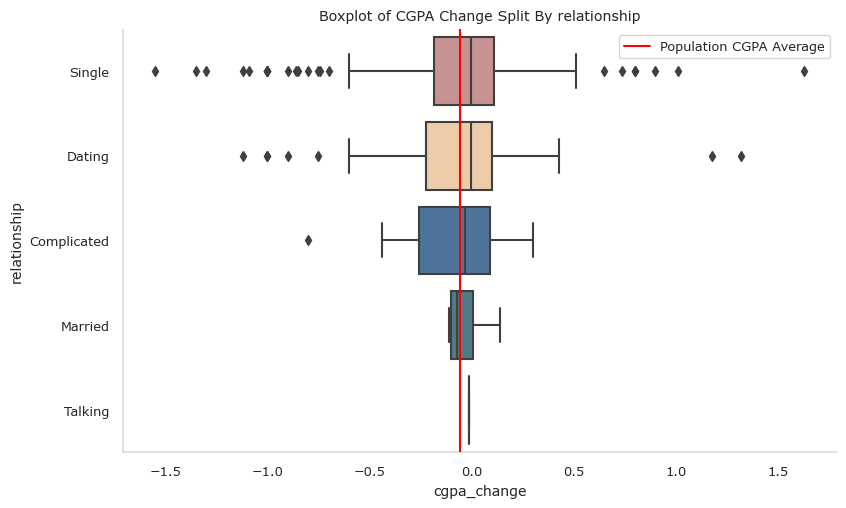

In [32]:
# Visualizing the difference
sns.catplot(
    kind='box',
    data=df_valid_cgpa,
    x='cgpa_change',
    y='relationship',
    aspect=12/7
)
plt.axvline(df_valid_cgpa.cgpa_change.mean(),color='red',label='Population CGPA Average')      
plt.legend(loc='upper right')                                                                           
plt.title('Boxplot of CGPA Change Split By relationship');

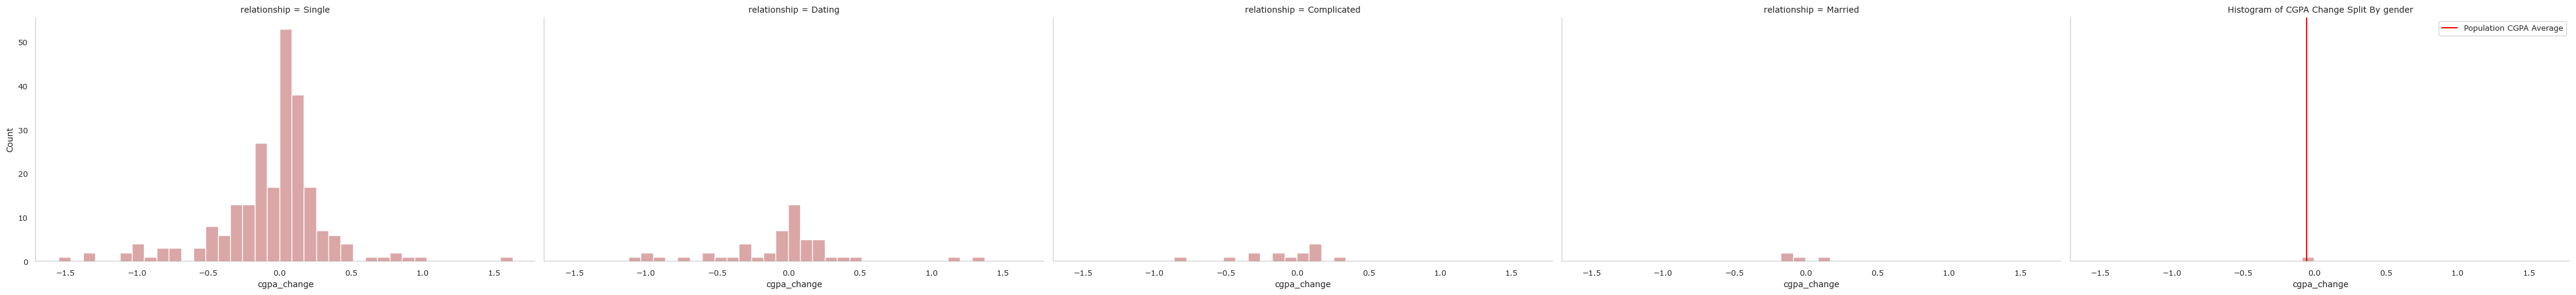

In [33]:
# Visualizing the results
sns.displot(
    kind='hist',
    data=df_valid_cgpa,
    x='cgpa_change',
    col='relationship',
    aspect=12/7
)
plt.axvline(df_valid_cgpa.cgpa_change.mean(),color='red',label='Population CGPA Average')      
plt.legend(loc='upper right')                                                                           
plt.title('Histogram of CGPA Change Split By gender');

The Boxplot and Histogram both confirm that the change in CGPA is independent of relationship status.                                                                    

# Worked

Feature: worked

Null Hypothesis: There is no significant difference in the cgpa of students with different working statuses.

Alternative Hypothesis: There is a significant difference in the cgpa of students with different working statuses. 

Test Type: Two Tailed Test

Statistical Test: One Way ANOVA Test

Significance Level: 0.05

ANOVA Test Assumptions:
1. The samples are independent.
2. Each sample is from a normally distributed population.
3. The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

## Confirming Assumptions 

In [34]:
worked_anova_assumptions = anova_assumptions_test(feature='work', target='cgpa_change', df=df_valid_cgpa)
print(worked_anova_assumptions)

The given data passes both tests of homoscedasticity and normality.


## Hypothesis Testing on work status.                                                                       

In [35]:
worked_hypothesis_test = perform_one_way_anova(feature='work', target='cgpa_change', df=df_valid_cgpa)
worked_hypothesis_test  

'ANOVA F-statistic:", 2.583026685351414, "ANOVA p-value:", 0.07721337074564746'

The p-value score of 0.077 is more than the significance level of 0.05 this means that we fail to reject the null hypothesis

**There is no significant difference between the average cgpa change across the different work status**                                                                     

## Interpreting the results

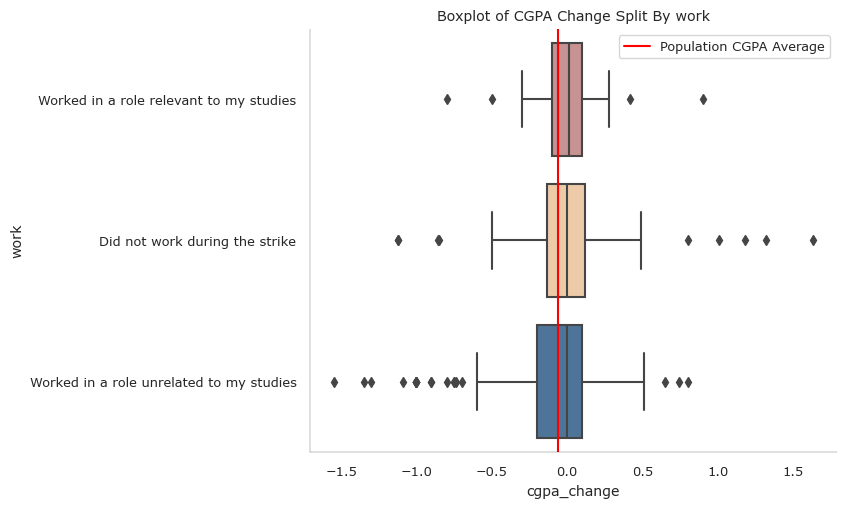

In [36]:
# Visualizing the result
sns.catplot(
    kind='box',
    data=df_valid_cgpa,
    x='cgpa_change',
    y='work',
    aspect=12/7
)
plt.axvline(df_valid_cgpa.cgpa_change.mean(),color='red',label='Population CGPA Average')      
plt.legend(loc='upper right')                                                                           
plt.title('Boxplot of CGPA Change Split By work');

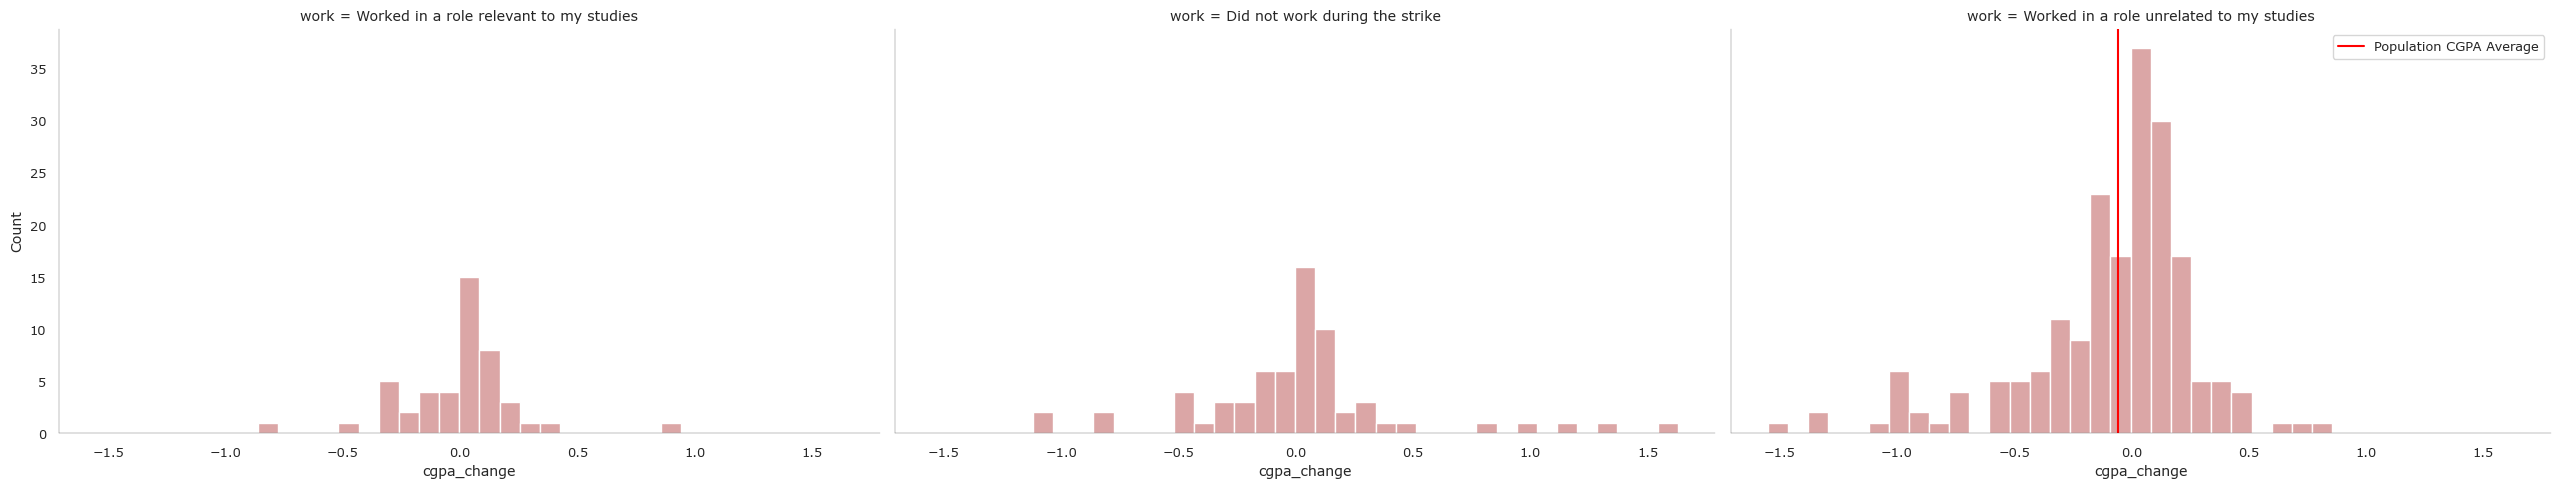

In [37]:
# Visualizing the results
sns.displot(
    kind='hist',
    data=df_valid_cgpa,
    x='cgpa_change',
    col='work',
    aspect=12/7
)
plt.axvline(df_valid_cgpa.cgpa_change.mean(),color='red',label='Population CGPA Average')      
plt.legend(loc='upper right')                                                                           
# plt.title('Histogram of CGPA Change Split By work');

The Boxplot and Histogram both confirm that the change in CGPA is independent of work status.                                                                    

# Academic Engagement

Feature: Academic Engagement

Null Hypothesis: There is no difference in the CGPA change across academic levels.

Alternative Hypothesis: There is a difference in the CGPA change across academic levels

Test Type: Two Tailed Test

Statistical Test: One Way ANOVA Test

Significance Level: 0.05

ANOVA Test Assumptions:
1. The samples are independent.
2. Each sample is from a normally distributed population.
3. The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

## Preprocessing

In [38]:
df_valid_cgpa.academic_act.unique()

array(['Rarely: I engaged in academic activities once or twice during the strike.',
       'Never: I did not engage in any academic activities during the strike.',
       'Often: I engaged in academic activities regularly, but not as often as I would during a normal semester.',
       'Sometimes: I engaged in academic activities occasionally, but not on a regular basis during the strike.',
       'Very often: I engaged in academic activities almost as often as I would during a normal semester.'],
      dtype=object)

In [39]:
df_valid_cgpa.academic_act.replace({'Very often: I engaged in academic activities almost as often as I would during a normal semester.':'very_often',
                                   'Sometimes: I engaged in academic activities occasionally, but not on a regular basis during the strike.':'sometimes',
                                   'Often: I engaged in academic activities regularly, but not as often as I would during a normal semester.':'often',
                                   'Never: I did not engage in any academic activities during the strike.':'Never',
                                   'Rarely: I engaged in academic activities once or twice during the strike.':'rarely'},
                                   inplace=True)

df_valid_cgpa.academic_act.unique()

array(['rarely', 'Never', 'often', 'sometimes', 'very_often'],
      dtype=object)

## Confirming Assumptions 

In [40]:
academic_act_anova_assumptions = anova_assumptions_test(feature='academic_act', target='cgpa_change', df=df_valid_cgpa)
print(academic_act_anova_assumptions)

The given data passes both tests of homoscedasticity and normality.


## Hypothesis Testing on Academic activities.                                                                      

In [41]:
academic_act_hypothesis_test = perform_one_way_anova(feature='academic_act', target='cgpa_change', df=df_valid_cgpa)
academic_act_hypothesis_test  

'ANOVA F-statistic:", 1.5554944954838623, "ANOVA p-value:", 0.18618784017777876'

The p-value score of 0.186 is greater than the significance level of 0.05 this means that we fail to reject the null hypothesis.

**There is no significant difference between the average cgpa change across the different academic activities**                                                                     

## Interpreting the results

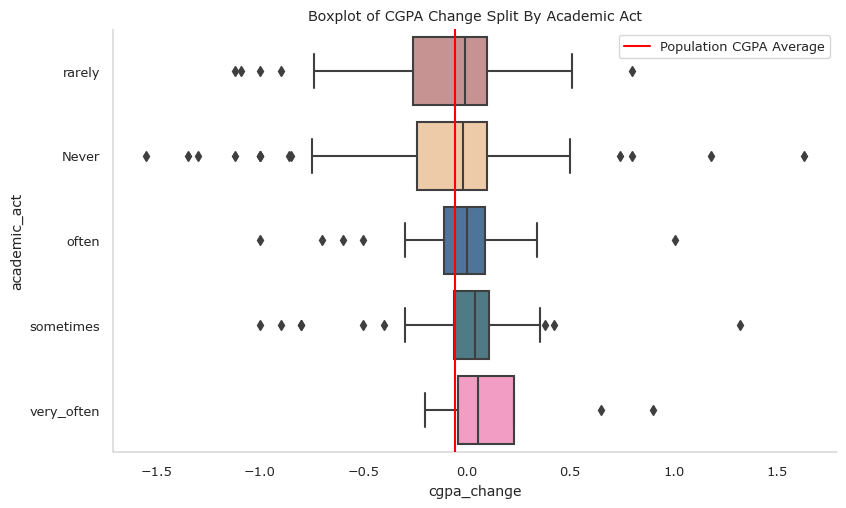

In [42]:
# Visualizing the difference
sns.catplot(
    kind='box',
    data=df_valid_cgpa,
    x='cgpa_change',
    y='academic_act',
    aspect=12/7
)
plt.axvline(df_valid_cgpa.cgpa_change.mean(),color='red',label='Population CGPA Average')      
plt.legend(loc='upper right')                                                                           
plt.title('Boxplot of CGPA Change Split By Academic Act');

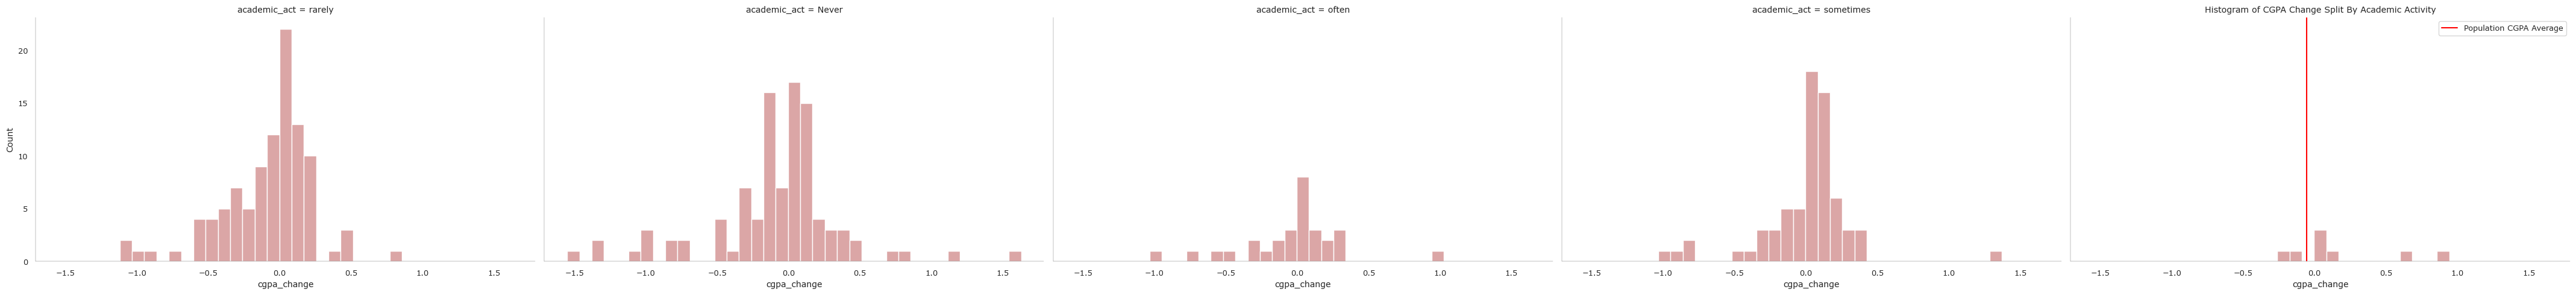

In [43]:
# Visualizing the results
sns.displot(
    kind='hist',
    data=df_valid_cgpa,
    x='cgpa_change',
    col='academic_act',
    aspect=12/7
)
plt.axvline(df_valid_cgpa.cgpa_change.mean(),color='red',label='Population CGPA Average')      
plt.legend(loc='upper right')                                                                           
plt.title('Histogram of CGPA Change Split By Academic Activity');

The Boxplot and Histogram both confirm that the change in CGPA is independent of Academic_act.                                                                    

# Lecture                                                                                  

Feature: Lecture

Null Hypothesis: There is no difference in the CGPA change across Lecture Effect.

Alternative Hypothesis:There is a difference in the CGPA change across Lecture Effect.

Test Type: Two Tailed Test

Statistical Test: One Way ANOVA Test

Significance Level: 0.05

ANOVA Test Assumptions:
1. The samples are independent.
2. Each sample is from a normally distributed population.
3. The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

## Confirming Assumptions 

In [44]:
lecture_anova_assumptions = anova_assumptions_test(feature='lecture', target='cgpa_change', df=df_valid_cgpa)
print(lecture_anova_assumptions)

The given data passes both tests of homoscedasticity and normality.


## Hypothesis Testing on Lecture Effects.

In [45]:
lecture_hypothesis_test = perform_one_way_anova(feature='lecture', target='cgpa_change', df=df_valid_cgpa)
lecture_hypothesis_test  

'ANOVA F-statistic:", 3.0837176943043434, "ANOVA p-value:", 0.01642350733045032'

The p-value score of 0.0164 is less than the significance level of 0.05 this means that we reject the null hypothesis

**There is a significant difference between the average cgpa change across the different Lecture effects**                                                                     

## Interpreting the difference

While we've confirmed that a significant difference exist among the Lecture Effects. The test carried out tells us nothing about the nature of this difference. To understand this difference, we can carry out post hoc tests to determine which specific pairs or groups differ significantly from the rest.                               

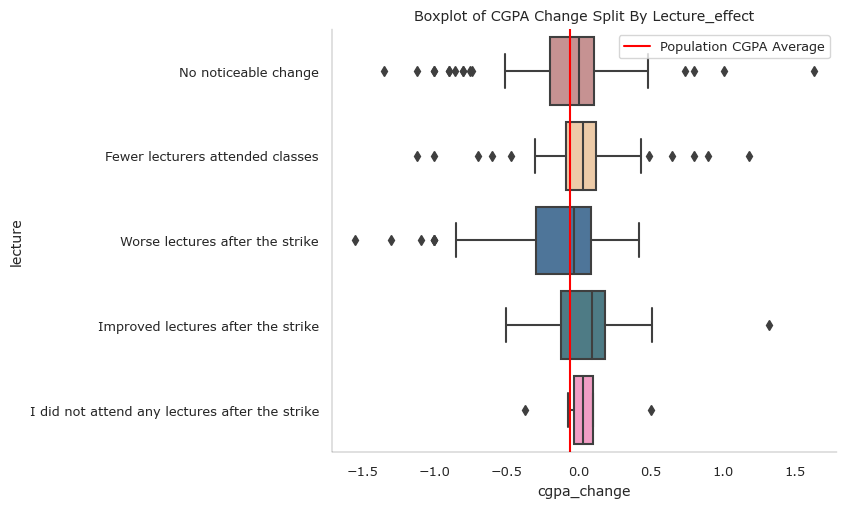

In [46]:
# Visualizing the difference
sns.catplot(
    kind='box',
    data=df_valid_cgpa,
    x='cgpa_change',
    y='lecture',
    aspect=12/7
)
plt.axvline(df_valid_cgpa.cgpa_change.mean(),color='red',label='Population CGPA Average')      
plt.legend(loc='upper right')                                                                           
plt.title('Boxplot of CGPA Change Split By Lecture_effect');

In [47]:
# Investigating pairwise differences                                                                                 
level_tukey_results = perform_pairwise_tukeyhsd(feature='lecture', target='cgpa_change', df=df_valid_cgpa)
level_tukey_results

                                        Multiple Comparison of Means - Tukey HSD, FWER=0.05                                         
                    group1                                         group2                     meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------------------------------------------------
              Fewer lecturers attended classes I did not attend any lectures after the strike   0.0116    1.0  -0.393  0.4161  False
              Fewer lecturers attended classes             Improved lectures after the strike   0.0624 0.9808 -0.2443  0.3692  False
              Fewer lecturers attended classes                           No noticeable change  -0.1013 0.3459 -0.2515  0.0489  False
              Fewer lecturers attended classes                Worse lectures after the strike   -0.175 0.0183 -0.3302 -0.0197   True
I did not attend any lectures after the strike             Improved l

From the table above, the strongest significant change was noticed in a pair containing "Worse Lecture after the strike". The Boxplot also showed that the group had the lowest 2nd quartile, lowest median value, lowest bottom whisker (minimum non-outlier value) and it was also the only group without a positive outlier. This overwhelmingly proves that those with worse lectures after the strike recieved the most negative impact on their CGPA.
          